In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

import keras as ks
from keras import layers
from keras import models

from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

In [3]:
def history_plot(history, items = ['loss']):
    fig = plt.figure(figsize=(13, 5))

    ax1  = fig.add_subplot(1,2 ,1, title= 'Accuracy' , xlabel = 'epoch' , ylabel = 'accuracy' )
    ax1.plot(history.history['val_acc'], label = 'Validation')
    ax1.plot(history.history['acc'], label = 'train acc')
    ax1.legend(loc=0)

    ax2  = fig.add_subplot(1,2,2, title='Loss')
    ax2.plot(history.history['val_loss'], label = 'test loss')
    ax2.plot(history.history['loss'], label = 'train loss')
    ax2.legend(loc=0)

    plt.tight_layout()
    plt.show()
    return None


def cv_score(clf, X, Y):
    score = cross_val_score(clf, X, Y, cv=5, scoring='accuracy')
#     print('For RandomForest, the accuracy is {}  +/- {}'.format( dm_score.mean(), dm_score.std())  )
    return score.mean(), score.std()

# Sec II

In [4]:
df1 = pd.read_csv('Data_2.csv')
df1.head()

,Label,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,200
0,0,0.660,0.106,0.434,0.387,0.903,0.661,0.158,0.291,0.210,...,0.015,0.377,0.479,0.050,0.395,0.123,0.833,0.461,0.990,0.105
1,1,0.844,0.813,0.030,0.939,0.721,0.287,0.539,0.874,0.787,...,0.112,0.048,0.088,0.860,0.560,0.346,0.511,0.883,0.858,0.599
2,0,0.560,0.567,0.568,0.434,0.414,0.180,0.448,0.888,0.023,...,0.874,0.236,0.599,0.602,0.005,0.493,0.122,0.395,0.782,0.943
3,0,0.681,0.245,0.909,0.785,0.738,0.570,0.692,0.411,0.182,...,0.219,0.691,0.261,0.031,0.968,0.353,0.798,0.104,0.944,0.090
4,0,0.846,0.431,0.805,0.237,0.465,0.642,0.219,0.102,0.795,...,0.704,0.242,0.089,0.605,0.577,0.043,0.686,0.070,0.666,0.572


In [8]:
'''
This is for a quick-and-dirty baseline, so we can afford to skip all the rows that contain nan. 
'''
df1.dropna(axis=0, inplace=True)
len(df1)

19997

In [9]:
'''
Making the feature and label matrices. 
'''
X = df1.values[:, 4:]
Y = df1['Label'].values

In [10]:
'''
Making the train and validation data sets. 
'''
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train,  Y_test = train_test_split(X, Y)

In [20]:
'''
Now, we train some simple models to get an idea of how well a simple model can do. 
Anything we do later, should be better than this baseline models.
It's generally a good idea to try a few simple model. 
'''
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier

model = SGDClassifier()
model.fit(X_train, Y_train)

print('For SGD, we have: /n')
print(f" The in_score is: {model.score(X_train, Y_train)}" )
print(f" The out_score is: {model.score(X_test, Y_test)}" )
print('-------------------------------------------\n')

model = RidgeClassifier()
model.fit(X_train, Y_train)

print('For Ridge clf, we have: /n')
print(f" The in_score is: {model.score(X_train, Y_train)}" )
print(f" The out_score is: {model.score(X_test, Y_test)}" )
print('-------------------------------------------\n')

model = LogisticRegression()
model.fit(X_train, Y_train)

print('For Logistic Regression, we have: /n')
print(f" The in_score is: {model.score(X_train, Y_train)}" )
print(f" The out_score is: {model.score(X_test, Y_test)}" )

For SGD, we have: /n
 The in_score is: 0.9337200773488031
 The out_score is: 0.9308
-------------------------------------------

For Ridge clf, we have: /n
 The in_score is: 0.9488564379542576
 The out_score is: 0.947
-------------------------------------------

For Logistic Regression, we have: /n
 The in_score is: 0.9323197972927919
 The out_score is: 0.9306


This would suffice  for a base-line model. Any model that you could manage to fit in less than 15 minutes would do. 

# Sec III

In [23]:
df2 = pd.read_csv('Data_3.csv', index_col=0)
df2.head()

,target,0,1,2,3,4,5,6,7,8,...,290,291,292,293,294,295,296,297,298,299
id,,,,,,,,,,,,,,,,,,,,,
0,1,-0.098,2.165,0.681,-0.614,1.309,-0.455,-0.236,0.276,-2.246,...,0.867,1.347,0.504,-0.649,0.672,-2.097,1.051,-0.414,1.038,-1.065
1,0,1.081,-0.973,-0.383,0.326,-0.428,0.317,1.172,0.352,0.004,...,-0.165,-1.695,-1.257,1.359,-0.808,-1.624,-0.458,-1.099,-0.936,0.973
2,1,-0.523,-0.089,-0.348,0.148,-0.022,0.404,-0.023,-0.172,0.137,...,0.013,0.263,-1.222,0.726,1.444,-1.165,-1.544,0.004,0.800,-1.211
3,1,0.067,-0.021,0.392,-1.637,-0.446,-0.725,-1.035,0.834,0.503,...,-0.404,0.640,-0.595,-0.966,0.900,0.467,-0.562,-0.254,-0.533,0.238
4,1,2.347,-0.831,0.511,-0.021,1.225,1.594,0.585,1.509,-0.012,...,0.898,0.134,2.415,-0.996,-1.006,1.378,1.246,1.478,0.428,0.253


In [24]:
print(f'There are only {len(df2)} samples in this data set, \n besides the challenge of finding a good model, this means that it would be easy to overfit.')

There are only 250 samples in this data set, 
 besides the challenge of finding a good model, this means that it would be easy to overfit.


In [25]:
'''
Making the train and validation data.
'''
X = df2.values[:, 1:]
Y = df2['target'].values

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train,  Y_test = train_test_split(X, Y, random_state=5)


## Baseline Model

In [26]:
from sklearn.dummy import DummyClassifier
dum_clf = DummyClassifier(strategy='most_frequent'  )
dum_clf.fit(X_train, Y_train)

dm_score = cross_val_score(dum_clf, X, Y, cv=5, scoring='accuracy')
print('For a dummy classifier, the accuracy is {}  +/- {}'.format( dm_score.mean(), dm_score.std())  )


For a dummy classifier, the accuracy is 0.64  +/- 0.0


In [32]:
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier

model = SGDClassifier()
model.fit(X_train, Y_train)
score = cross_val_score(model, X, Y, cv=5, scoring='accuracy')

print('For SGD, we have: /n')
print(f" The in_score is: {model.score(X_train, Y_train)}" )
print(f" The out_score is: {model.score(X_test, Y_test)}" )
print(f'The cross-validated score is {score.mean():.3} +/- {score.std():.3}. ')
print('-------------------------------------------\n')

model = RidgeClassifier()
model.fit(X_train, Y_train)
score = cross_val_score(model, X, Y, cv=5, scoring='accuracy')

print('For Ridge clf, we have: /n')
print(f" The in_score is: {model.score(X_train, Y_train)}" )
print(f" The out_score is: {model.score(X_test, Y_test)}" )
print(f'The cross-validated score is {score.mean():.3} +/- {score.std():.3}. ')
print('-------------------------------------------\n')

model = LogisticRegression()
model.fit(X_train, Y_train)
score = cross_val_score(model, X, Y, cv=5, scoring='accuracy')

print('For Logistic Regression, we have: /n')
print(f" The in_score is: {model.score(X_train, Y_train)}" )
print(f" The out_score is: {model.score(X_test, Y_test)}" )
print(f'The cross-validated score is {score.mean():.3} +/- {score.std():.3}. ')

For SGD, we have: /n
 The in_score is: 1.0
 The out_score is: 0.7777777777777778
The cross-validated score is 0.664 +/- 0.0496. 
-------------------------------------------

For Ridge clf, we have: /n
 The in_score is: 1.0
 The out_score is: 0.6984126984126984
The cross-validated score is 0.632 +/- 0.0466. 
-------------------------------------------

For Logistic Regression, we have: /n
 The in_score is: 1.0
 The out_score is: 0.8095238095238095
The cross-validated score is 0.688 +/- 0.0371. 


You can see that none of these model can outperform (at least not significantly) the dummy classifier. 
Let's try a random forest classifier!

In [11]:
%%time
from sklearn.ensemble import RandomForestClassifier
baseline_model = RandomForestClassifier(n_estimators=500, bootstrap=True, verbose=0)
baseline_model.fit(X_train,Y_train)

Wall time: 1.71 s


In [8]:
rf_score = cross_val_score(baseline_model, X, Y, cv=5, scoring='accuracy')
print('For RandomForest, the accuracy is {}  +/- {}'.format( rf_score.mean(), rf_score.std())  )

For RandomForest, the accuracy is 0.656  +/- 0.014966629547095779


In [8]:
rf_score = cross_val_score(baseline_model, X, Y, cv=5, scoring='accuracy')
print('For RandomForest, the accuracy is {}  +/- {}'.format( rf_score.mean(), rf_score.std())  )

For RandomForest, the accuracy is 0.656  +/- 0.014966629547095779


Almost as bad.

## Data reduction

Clearly, 250 samples is not enough for find a good model, even for a linear model, we need to specify 300 coefficients and we simply don't have enough data. 

It makes sense to reduce the parameter space. 

We use a simple reduction based on the coefficients of the linear logistic regression. 

You probably could use other techniques like important features of  decision tree or PCA.

In [39]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(class_weight='balanced', penalty='l1', C=0.1)
model.fit(X_train, Y_train)
score = cross_val_score(model, X, Y, cv=5, scoring='accuracy')
print('For RandomForest, the accuracy is {}  +/- {}'.format( score.mean(), score.std())  )

For RandomForest, the accuracy is 0.7  +/- 0.021908902300206624


In [40]:
ws = model.coef_
print(f'There are {len(ws[ws!=0])} non-zero weights.')
to_keep_ind = (ws!=0).reshape(-1)

There are 24 non-zero weights.


This indicates that 34(this could change based on the train and test split) of the coefs would play a role. So we only keep those. This would significantly help up not overfit. 

In [41]:
X_red = X[:,to_keep_ind]
X_red_train, X_red_test, Y_red_train,  Y_red_test = train_test_split(X_red, Y)

In [42]:
# model = RandomForestClassifier(n_estimators=500, bootstrap=True, verbose=0, class_weight='balanced') 
model = LogisticRegression(class_weight='balanced', penalty='l1', C=0.1, solver='liblinear')
model.fit(X_red_train, Y_red_train)
score = cross_val_score(model, X_red, Y, cv=5, scoring='accuracy')
print('For RandomForest, the accuracy is {}  +/- {}'.format( score.mean(), score.std())  )

For RandomForest, the accuracy is 0.716  +/- 0.0463033476111609


This improves the performance of a random forest clf to ~75%.

In [43]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=500, bootstrap=True, verbose=0, class_weight='balanced') 
# model = LogisticRegression(class_weight='balanced', penalty='l1', C=0.1, solver='liblinear')
model.fit(X_red_train, Y_red_train)
score = cross_val_score(model, X_red, Y, cv=5, scoring='accuracy')
print('For RandomForest, the accuracy is {}  +/- {}'.format( score.mean(), score.std())  )

For RandomForest, the accuracy is 0.776  +/- 0.02939387691339813


In [76]:
nn_model = models.Sequential()
nn_model.add( layers.Dense( 100 , activation = 'relu', kernel_regularizer=ks.regularizers.l2(l=0.1)) )
nn_model.add(layers.Dropout(.2) )
nn_model.add( layers.Dense( 50 , activation = 'relu', kernel_regularizer=ks.regularizers.l2(l=0.1)) )
nn_model.add(layers.Dropout(.2) )
nn_model.add( layers.Dense( 1 , activation = 'sigmoid') )

nn_model.compile(loss = ks.losses.binary_crossentropy, 
             optimizer = ks.optimizers.Adam(lr = .001))

nn_model.metrics = ['accuracy']

nn_model.build(input_shape = (None, X_red_test.shape[-1] ) )
nn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_43 (Dense)             (None, 100)               2500      
_________________________________________________________________
dropout_30 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_44 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_31 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_45 (Dense)             (None, 1)                 51        
Total params: 7,601
Trainable params: 7,601
Non-trainable params: 0
_________________________________________________________________


Train on 187 samples, validate on 63 samples
Epoch 1/50
187/187 [==============================] - 3s 14ms/step - loss: 9.7207 - acc: 0.6364 - val_loss: 8.2100 - val_acc: 0.5556
Epoch 2/50
187/187 [==============================] - 0s 1ms/step - loss: 7.0602 - acc: 0.6791 - val_loss: 5.9399 - val_acc: 0.5714
Epoch 3/50
187/187 [==============================] - 0s 2ms/step - loss: 5.0842 - acc: 0.6898 - val_loss: 4.3008 - val_acc: 0.5714
Epoch 4/50
187/187 [==============================] - 0s 2ms/step - loss: 3.6747 - acc: 0.6684 - val_loss: 3.1329 - val_acc: 0.5714
Epoch 5/50
187/187 [==============================] - 0s 2ms/step - loss: 2.6758 - acc: 0.6738 - val_loss: 2.3187 - val_acc: 0.5714
Epoch 6/50
187/187 [==============================] - 0s 2ms/step - loss: 1.9787 - acc: 0.6684 - val_loss: 1.7595 - val_acc: 0.5714
Epoch 7/50
187/187 [==============================] - 0s 2ms/step - loss: 1.5065 - acc: 0.6631 - val_loss: 1.3761 - val_acc: 0.5714
Epoch 8/50
187/187 [==========

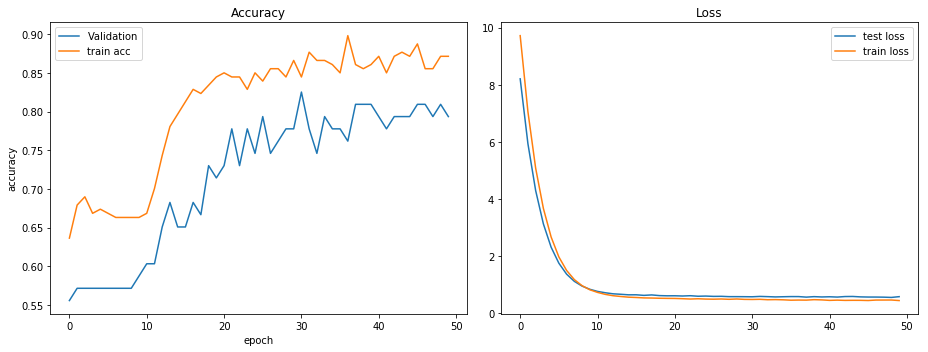

Wall time: 19.8 s


In [71]:
%%time
history = nn_model.fit(X_red_train, Y_red_train, batch_size= 8, 
                      epochs=50, 
#                        verbose = 0, 
                      validation_data=(X_red_test, Y_red_test) )

history_plot(history)

In [25]:
nn_model.save('exam_secIII.hd5')
np.save('to_keep_ind', to_keep_ind)

This clearly is still overfitting, but at least the validation score is around 80%.

## Bootstrapping

In [74]:
'''
But we can do a lot better. The main challenge is that we don't have enough data, so we can more by bootstrapping. 
'''
from sklearn.utils import resample
X_bts, Y_bts = resample( X_red, Y, n_samples=1000)

from sklearn.model_selection import train_test_split
X_bts_train, X_bts_test, Y_bts_train,  Y_bts_test = train_test_split(X_bts, Y_bts, random_state=0)

Train on 750 samples, validate on 250 samples
Epoch 1/100
750/750 [==============================] - 4s 5ms/step - loss: 6.6175 - acc: 0.6387 - val_loss: 3.3183 - val_acc: 0.6920
Epoch 2/100
750/750 [==============================] - 1s 2ms/step - loss: 2.0110 - acc: 0.6427 - val_loss: 1.1483 - val_acc: 0.6920
Epoch 3/100
750/750 [==============================] - 2s 2ms/step - loss: 0.8691 - acc: 0.6587 - val_loss: 0.6583 - val_acc: 0.7800
Epoch 4/100
750/750 [==============================] - 1s 2ms/step - loss: 0.6164 - acc: 0.7560 - val_loss: 0.5573 - val_acc: 0.8480
Epoch 5/100
750/750 [==============================] - 2s 2ms/step - loss: 0.5548 - acc: 0.8253 - val_loss: 0.5213 - val_acc: 0.8520
Epoch 6/100
750/750 [==============================] - 2s 2ms/step - loss: 0.5314 - acc: 0.8360 - val_loss: 0.5052 - val_acc: 0.8560
Epoch 7/100
750/750 [==============================] - 2s 2ms/step - loss: 0.5113 - acc: 0.8587 - val_loss: 0.4953 - val_acc: 0.8440
Epoch 8/100
750/750 [==

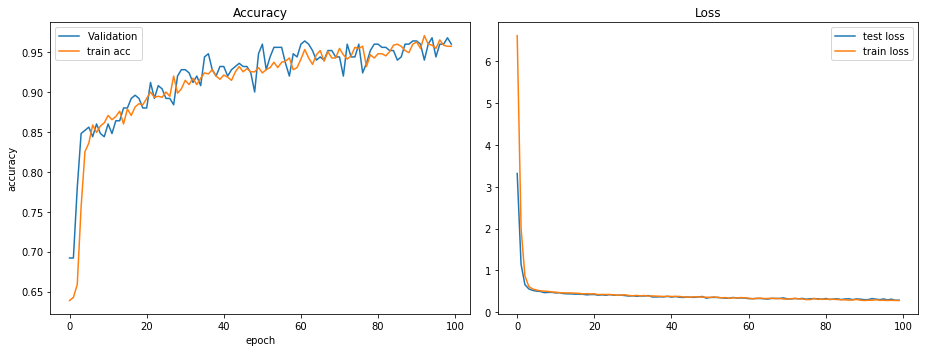

Wall time: 2min 20s


In [77]:
%%time
history = nn_model.fit(X_bts_train, Y_bts_train, batch_size= 8, 
                      epochs=100, 
#                        verbose = 0, 
                      validation_data=(X_bts_test, Y_bts_test) )

history_plot(history)

In [78]:
nn_model.save('exam_secIII_bts.hd5')

This takes us to above 95% with just some simple ideas that we covered in our course. 

I hope you had fun!